In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.keras.backend.set_floatx('float64')

tf.autograph.set_verbosity(0)

2023-04-19 11:58:22.313535: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 11:58:22.460284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 11:58:22.461489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 11:58:24.397358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)

In [5]:
def gen_data(m, seed=1, scale=0.7):
    """ generate a data set based on a x^2 with added noise """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = x_train #for redraw when new data included in X
    return x_train, y_train, x_ideal, y_ideal

In [6]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


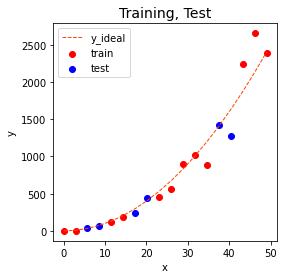

In [8]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = "blue",   label="test")
ax.legend(loc='upper left')
plt.show()

In [9]:
class lin_model:
    def __init__(self, degree, regularization = False, lambda_=0):
        if regularization:
            self.linear_model = Ridge(alpha=lambda_)
        else:
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias=False)
        self.scaler = StandardScaler()
        
    def fit(self, X_train,y_train):
        ''' just fits the data. mapping and scaling are not repeated '''
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train )

    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return(yhat)
    
    def mse(self, y, yhat):
        err = mean_squared_error(y,yhat)/2   #sklean doesn't have div by 2
        return (err)

In [11]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [14]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


In [13]:
def plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.set_title("Poor Performance on Test Data",fontsize = 12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.scatter(X_train, y_train, color = "red",           label="train")
    ax.scatter(X_test, y_test,       color = "blue", label="test")
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(x, y_pred,  lw=0.5, label=f"predicted, degree={degree}")
    ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

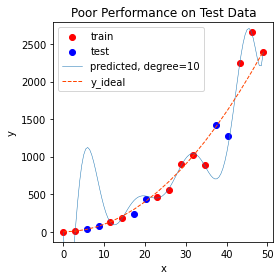

In [15]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

In [16]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


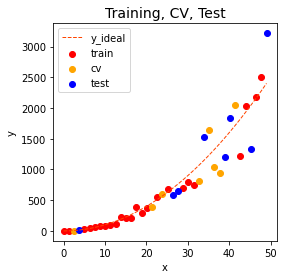

In [17]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = "orange", label="cv")
ax.scatter(X_test, y_test,   color = "blue",   label="test")
ax.legend(loc='upper left')
plt.show()

In [18]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

In [19]:
def plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = "orange", label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,max_degree):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"{i+1}")
    ax[0].legend(loc='upper left')

    ax[1].set_title("error vs degree",fontsize = 12)
    cpts = list(range(1, max_degree+1))
    ax[1].plot(cpts, err_train[0:], marker='o',label="train error", lw=2,  color = "blue")
    ax[1].plot(cpts, err_cv[0:],    marker='o',label="cv error",  lw=2, color = "orange")
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].axvline(optimal_degree, lw=1, color = "magenta")
    ax[1].annotate("optimal degree", xy=(optimal_degree,80000),xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                                   color='darkred', lw=1))
    ax[1].set_xlabel("degree")
    ax[1].set_ylabel("error")
    ax[1].legend()
    fig.suptitle("Find Optimal Degree",fontsize = 12)
    plt.tight_layout()

    plt.show()

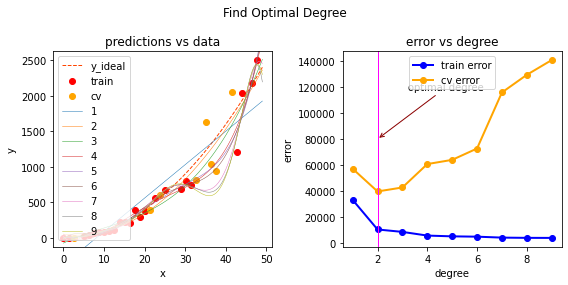

In [20]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

In [21]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

In [22]:
def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = "orange", label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
    for i in (0,3,7,9):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
    ax[0].legend()

    ax[1].set_title("error vs regularization",fontsize = 12)
    ax[1].plot(lambda_range, err_train[:], label="train error", color = "blue")
    ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = "orange")
    ax[1].set_xscale('log')
    ax[1].set_ylim(*ax[1].get_ylim())
    opt_x = lambda_range[optimal_reg_idx]
    ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
    ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                  arrowprops={'arrowstyle':'simple'})
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color = "blue")
    ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color = "blue")
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

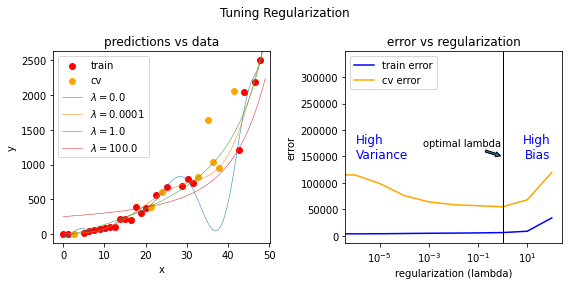

In [23]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

In [24]:
def tune_m():
    """ tune the number of examples to reduce overfitting """
    m = 50
    m_range = np.array(m*np.arange(1,16))
    num_steps = m_range.shape[0]
    degree = 16
    err_train = np.zeros(num_steps)     
    err_cv = np.zeros(num_steps)        
    y_pred = np.zeros((100,num_steps))     
    
    for i in range(num_steps):
        X, y, y_ideal, x_ideal = gen_data(m_range[i],5,0.7)
        x = np.linspace(0,int(X.max()),100)  
        X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
        X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)

        lmodel = lin_model(degree)  # no regularization
        lmodel.fit(X_train, y_train)
        yhat = lmodel.predict(X_train)
        err_train[i] = lmodel.mse(y_train, yhat)
        yhat = lmodel.predict(X_cv)
        err_cv[i] = lmodel.mse(y_cv, yhat)
        y_pred[:,i] = lmodel.predict(x)
    return(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree)

def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):
    
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           s=3, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color = "orange", s=3, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,len(m_range),3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"$m =${m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = "blue")

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color = "blue")
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color = "orange")
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color = "blue")
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color = "blue")
    ax[1].legend()
    plt.tight_layout()
    plt.show()  

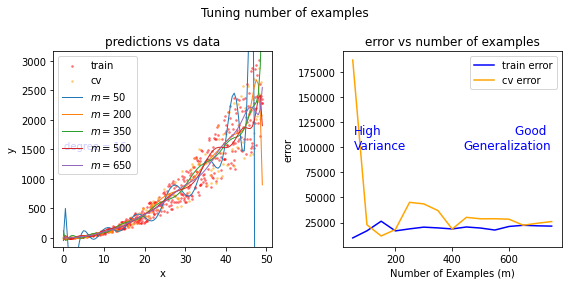

In [25]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)